In [14]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

# Contextualização: 

Bem-vindo à Machine Learning Housing Corporation!
A primeira tarefa que lhe é atribuída é construir um modelo de preços de imóveis na Califórnia utilizando os dados do censo da Califórnia. Esses dados contêm métricas como população, renda mediana, preço mediano dos imóveis, entre outras, para cada block group da Califórnia. Block groups são a menor unidade geográfica para a qual o US Census Bureau publica dados amostrais (um block group normalmente possui uma população entre 600 e 3.000 pessoas). Vamos chamá-los simplesmente de “distritos” para simplificar. Seu modelo deve aprender a partir desses dados e ser capaz de prever o preço mediano dos imóveis em qualquer distrito, dadas todas as outras métricas disponíveis.

A primeira pergunta que você deve fazer ao seu chefe é qual é exatamente o objetivo de negócio; construir um modelo provavelmente não é o objetivo final. Como a empresa espera usar esse modelo e se beneficiar dele? Isso é importante porque determinará como você irá formular o problema, quais algoritmos irá selecionar, qual medida de desempenho usará para avaliar o modelo e quanto esforço deverá gastar ajustando-o. Seu chefe responde que a saída do seu modelo (uma previsão do preço mediano dos imóveis de um distrito) será alimentada em outro sistema de Machine Learning (ver Figura 2-2), juntamente com muitos outros sinais. Esse sistema posterior determinará se vale a pena ou não investir em uma determinada área. Acertar isso é fundamental, pois afeta diretamente a receita.

A próxima pergunta a ser feita é como é a solução atual (se existir). Ela frequentemente fornece uma referência de desempenho, além de insights sobre como resolver o problema. Seu chefe responde que, atualmente, os preços dos imóveis por distrito são estimados manualmente por especialistas: uma equipe reúne informações atualizadas sobre um distrito e, quando não consegue obter o preço mediano dos imóveis, faz uma estimativa usando regras complexas. Esse processo é caro e demorado, e as estimativas não são muito boas; nos casos em que conseguem descobrir o preço mediano real dos imóveis, frequentemente percebem que as estimativas estavam erradas em mais de 20%. É por isso que a empresa acredita que seria útil treinar um modelo para prever o preço mediano dos imóveis de um distrito com base em outros dados sobre esse distrito. Os dados do censo parecem ser um excelente conjunto de dados para explorar esse propósito, pois incluem os preços medianos dos imóveis de milhares de distritos, além de outras informações relevantes.

Muito bem, com todas essas informações você já está pronto para começar a projetar seu sistema. Primeiro, você precisa formular o problema: ele é supervisionado, não supervisionado ou de Reinforcement Learning? É uma tarefa de classificação, regressão ou outra coisa? Você deve usar técnicas de aprendizado em lote (batch learning) ou aprendizado online?

Antes de continuar a leitura, pause e tente responder a essas perguntas por conta própria.

Você encontrou as respostas? Vamos ver: trata-se claramente de uma tarefa típica de aprendizado supervisionado, já que você recebe exemplos de treinamento rotulados (cada instância vem com a saída esperada, isto é, o preço mediano dos imóveis do distrito). Além disso, é também uma tarefa típica de regressão, pois você está tentando prever um valor numérico. Mais especificamente, este é um problema de regressão múltipla, já que o sistema usará múltiplas características para fazer a previsão (como população do distrito, renda mediana etc.). Também é um problema de regressão univariada, pois estamos tentando prever apenas um único valor para cada distrito. Se estivéssemos tentando prever múltiplos valores por distrito, seria um problema de regressão multivariada. Por fim, não há um fluxo contínuo de dados entrando no sistema, não existe uma necessidade particular de se ajustar rapidamente a dados em mudança, e o conjunto de dados é pequeno o suficiente para caber na memória. Portanto, o aprendizado em lote (batch learning) simples é mais do que suficiente.

# 1. Visualização do dataset

In [15]:
housing = pd.read_csv("../datasets/housing.csv")
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## 1.1 Exploração inicial

In [16]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


```python 
# - Total de linhas     20640
# - longitude           20640 -> ok
# - latitude            20640 -> ok
# - housing_median_age  20640 -> ok
# - total_rooms         20640 -> ok
# - total_bedrooms      20433 -> 207 linhas vazias (ATENÇÃO)
# - population          20640 -> ok
# etc 
```

O número percentual de linnhas vazias na coluna total_bedrooms: 207 / 20640 ≈ 1%

## 1.2 Tratando espaços vazios

Muitos algoritmos não aceitam valores ausentes (NaN) ou quebram silenciosamente ou aprendem errado. Não é indicado remover linhas, pois isso acarreta na perda de dados e na possibilidade de introduzir viés. Remover a coluna inteira também não é interessante, pois perderemos informações potencialmente importantes

```python
# Método 1: Manual 
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) # Preenchendo espaços vazios com a mediana 

# Método 2: Automático 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
```

A estratégia acima é a mais indicada pois: 

- Preserva o dataset 
- É bastante simples 
- É robusto a outliers 

Contudo, não aplicaremos isso agora, apenas na fase de preparação pra o ML

# 2. Train set x Test set

Poderíamos utilizar train_test_split

```python 
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(
    housing, test_size=0.2, random_state=42
)
``` 

Essa função:

- Embaralha os dados
- Separa 80% para treino e 20% para teste 
- Porém isso não garante que variáveis importantes tenham a mesma distribuição (podendo gerar viés amostral)

Porém, conhecemos uma feature crítica para a análise que estamos fazendo: "median_income". Com isso em mente, antes de criar os datasets, precisamos criar uma feature nova que agrupa os valores em determinadas categorias. Além disso, precisamos de outro método para a criação dos dasets de treino e teste para que evitemos sampling bias.

In [17]:
housing["income_cat"] = pd.cut(
    x=housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, float('inf')],
    labels=[1, 2, 3, 4, 5])

# 0.0 a 1.5 (15k) -> 1 
# 1.5 a 3.0 -> 2 
# 3.0 a 4.5 - > 3
# 4.5 a 6.0 -> 4 
# 6.0 a inf - > 5 
housing["income_cat"]

0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

Text(0.5, 0, 'Category')

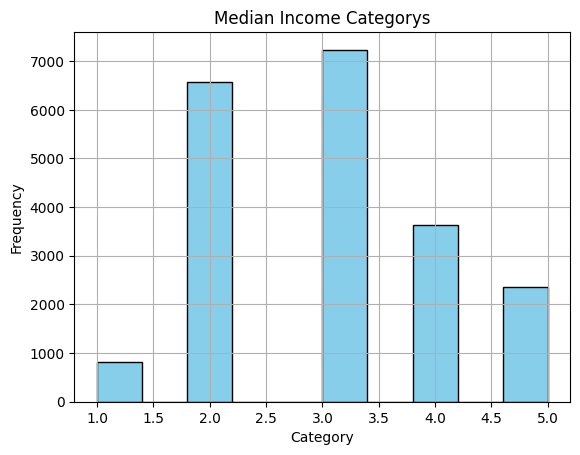

In [18]:
housing["income_cat"].hist(bins=10, color='skyblue', edgecolor='black')
plt.title("Median Income Categorys")
plt.ylabel("Frequency")
plt.xlabel("Category")

### Viés de Amostragem (Sampling Bias)

Sampling bias acontece quando o conjunto de dados usado (especialmente o de teste) não representa bem a população real. Onde exatamente está o sampling bias? Não está no algoritmo, não está no treinamento, não está nas features, **está na forma como o test set é construído**. E por que isso quebra a avaliação? Imagine poucas regiões ricas no teste, como casas caras são difíceis de prever e o modelo normalmente erra mais nelas, o erro médio fica artificialmente baixo, logo você acha que o modelo é ótimo mas ele só foi pouco testado onde mais erra. Agora imagine o contrário, muitas regiões ricas no teste implicam em muitas casas caras, logo muitos erros grandes, assim você acha que o modelo é ruim mas ele foi testado mais forte do que deveria. 

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,                    # n_splits=1 -> Crie uma única divisão treino–teste
    test_size=0.2,                 # test_size=0.2 -> O dataset de treino e de teste terão respectivamente 80% e 20% do tamanho original
    random_state=42                # random_state=42 -> Mantém a aleatoriedade constante mesmo rodando o código várias vezes
)


for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    housing_train = housing.loc[train_idx]
    housing_test = housing.loc[test_idx]

O que o trecho acima faz de diferente

- Usa uma variável de estratificação (income_cat)
- Divide os dados em estratos (grupos homogêneos)
- Garante que a proporção de cada estrato seja mantida
- Ainda assim embaralha aleatoriamente dentro de cada estrato

Ou seja, o teste “parece” com o treino no que importa.

### Quando usar cada um: 

- Use split aleatório simples quando: **dataset é enorme**, **distribuição é bem homogênea**, **nenhuma variável domina o target**
- Use estratificação quando: **variável importante é desbalanceada**, **dataset é médio ou pequeno**, **você já conhece uma feature crítica**